# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [2]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
#your turn
df_transactions.shape

(324, 3)

In [6]:
df_offers.shape

(32, 7)

In [7]:
df_merged=pd.merge(df_transactions, df_offers, how='outer', on='offer_id')
df=pd.pivot_table(df_merged,values='n', index='customer_name', columns='offer_id', aggfunc='count', fill_value=0)
df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Smaller SS values represent lower inertia values and hence better clustering. 

In [8]:
x_cols=np.matrix(df[1:])

In [9]:
kmeans=KMeans()
clusters_p=kmeans.fit_transform(x_cols)

In [10]:
ks=range(2,11)
ss=[]
for k in ks:
    kmeans=KMeans(n_clusters=k, random_state=1)
    kmeans.fit(x_cols)
    ss.append(kmeans.inertia_)

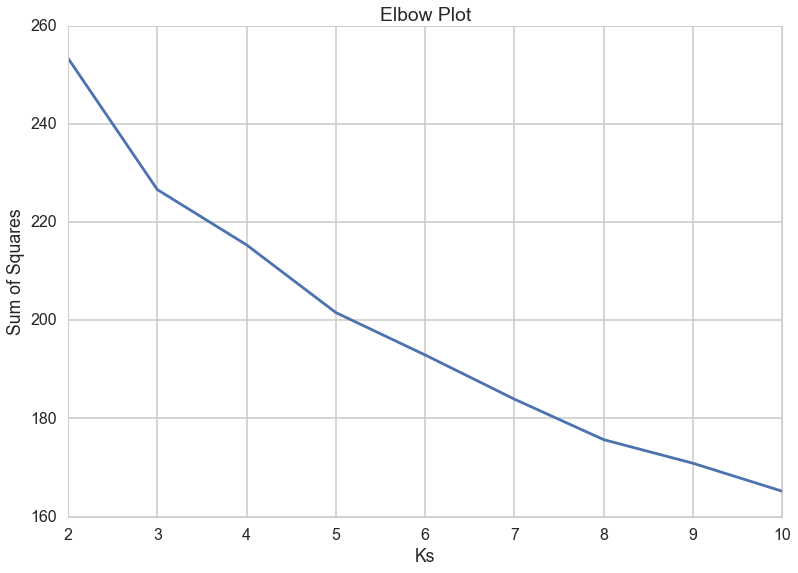

In [11]:
plt.plot(ks, ss)
plt.xlabel('Ks')
plt.ylabel('Sum of Squares')
plt.title('Elbow Plot')
plt.show()

The largest bend in this elbow plot is at 3 means but there are significant improvements at 5 and 8 as well.

In [12]:
cluster_p=KMeans(n_clusters=3, random_state=1).fit_predict(x_cols)

0    48
1    36
2    15
dtype: int64


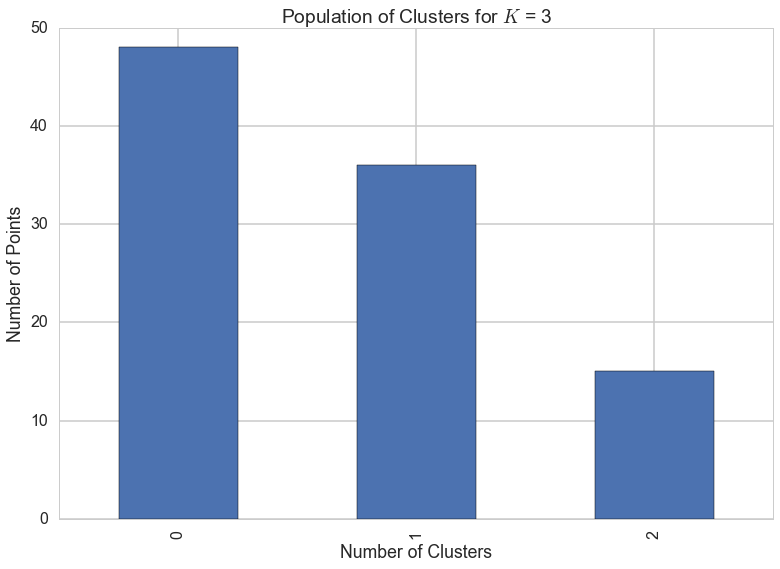

In [13]:
cluster_pop = pd.Series(cluster_p).value_counts().sort_index()
print(cluster_pop)

cluster_pop.plot(kind='bar')
plt.ylabel('Number of Points')
plt.xlabel('Number of Clusters')
plt.title('Population of Clusters for $K$ = 3')
plt.show()

The elbow plot made it difficult to determine where the cluster with the largest bent is.  As I stated above, one could choose 3, 5 or 8 as the optimal number of clusters

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [14]:
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.08936358915154788
For n_clusters = 3 The average silhouette_score is : 0.11964365320237129
For n_clusters = 4 The average silhouette_score is : 0.12323222596254917
For n_clusters = 5 The average silhouette_score is : 0.08723503578414539
For n_clusters = 6 The average silhouette_score is : 0.13080575578013445
For n_clusters = 7 The average silhouette_score is : 0.11397923415156692
For n_clusters = 8 The average silhouette_score is : 0.11470100618763072
For n_clusters = 9 The average silhouette_score is : 0.1040858357393102
For n_clusters = 10 The average silhouette_score is : 0.1369170979771135


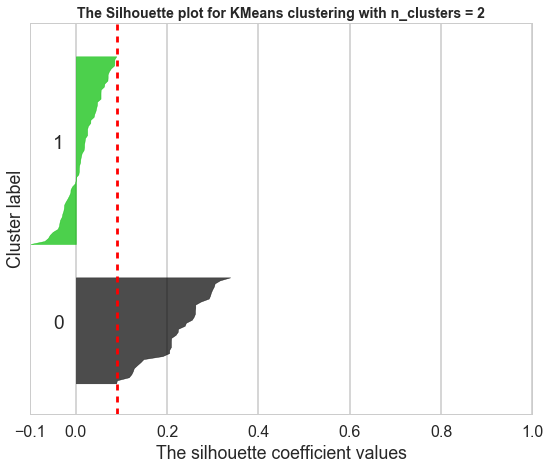

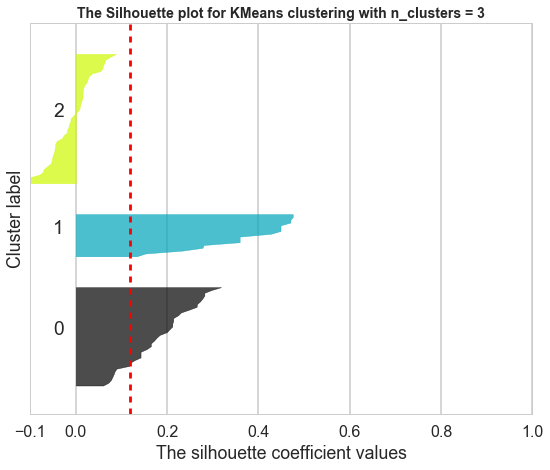

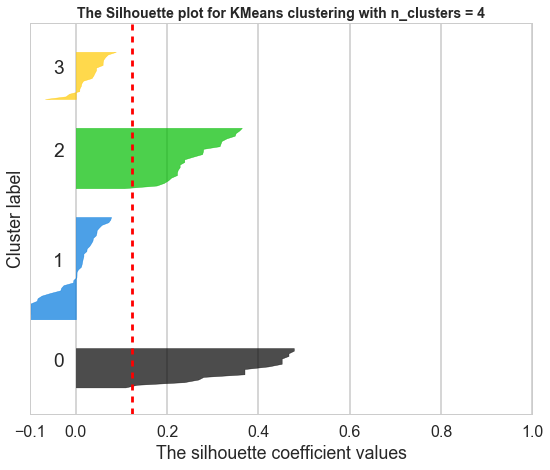

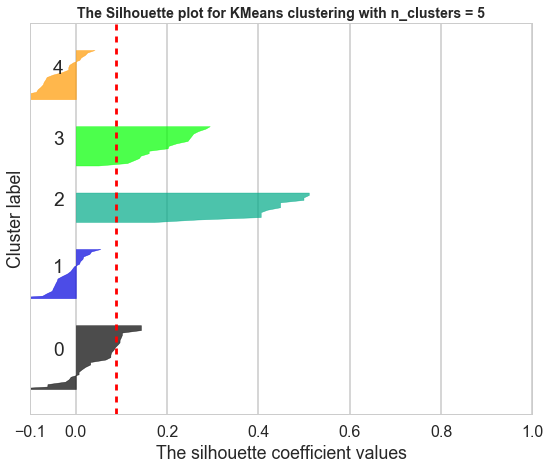

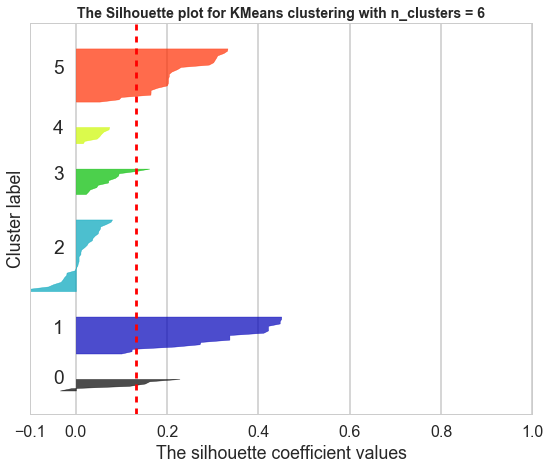

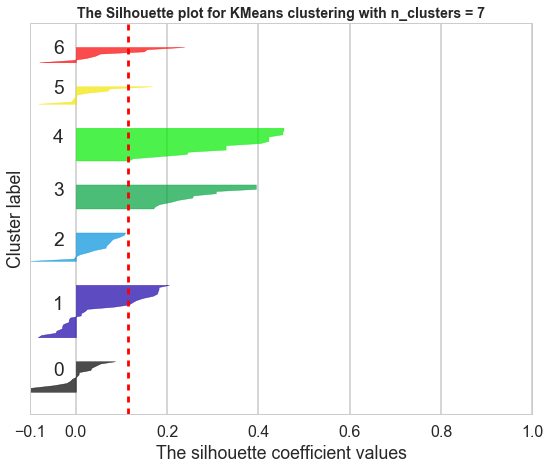

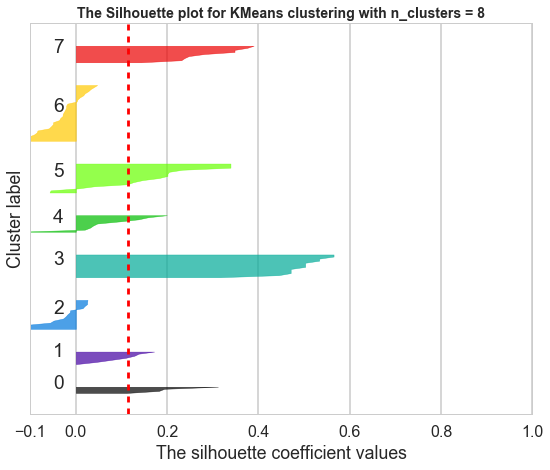

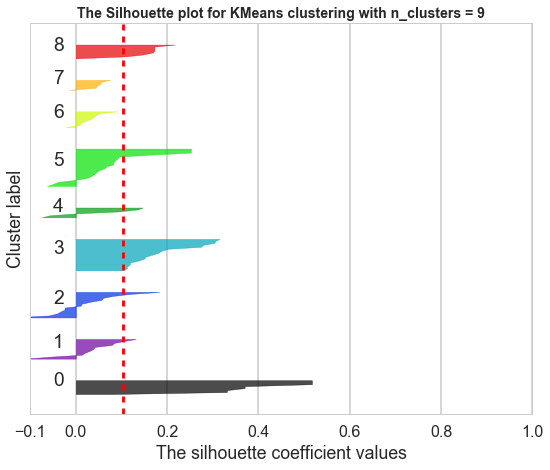

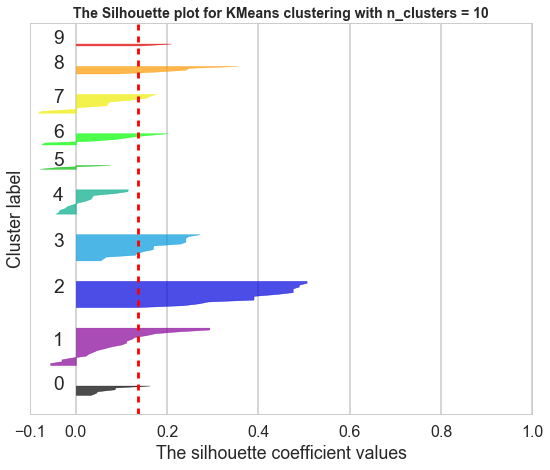

In [15]:
range_clusters = range(2,11)
silhouette_avg_scores = []

for n_clusters in range_clusters:
    
    fig, ax1 = plt.subplots(1, 1)
    _ = fig.set_size_inches(9, 7)

    _ = ax1.set_xlim([-0.1, 1])
    _ = ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        _ = ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        _ = ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    _ = ax1.set_title(("The Silhouette plot for KMeans clustering with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
    _ = ax1.set_xlabel("The silhouette coefficient values")
    _ = ax1.set_ylabel("Cluster label")

    _ = ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    _ = ax1.set_yticks([]) 
    _ = ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

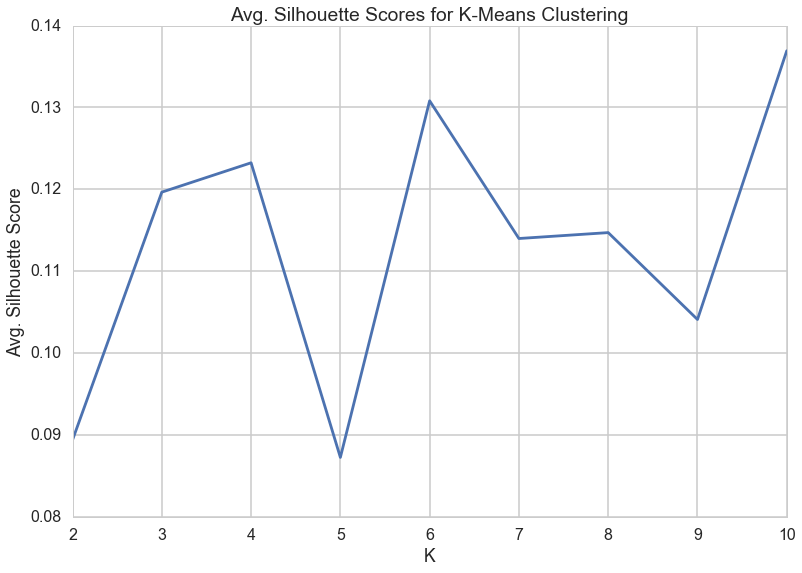

In [16]:
plt.plot(range_clusters, silhouette_avg_scores)
plt.xlabel('K')
plt.ylabel('Avg. Silhouette Score')
plt.title('Avg. Silhouette Scores for K-Means Clustering')
plt.show()

The silhouette method shows that the best number of clusters is 10, which is different from the 3,5,8 suggestions from the elbow plot.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [20]:
#your turn
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
#Build the dataframe
df_pca=pd.DataFrame(np.array(df.index))
#Initalize the clusterer
clusterer=KMeans(n_clusters=3)
clusterer.fit_predict(x_cols)
#Continue Building the DataFrame
df_pca['cluster_label']=pd.DataFrame(clusterer.fit_predict(x_cols))
df_pca['x']=pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,0]
df_pca['y']=pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,1]
df_pca.columns=['customer_name', 'cluster_label', 'x', 'y']
print(df_pca)

   customer_name  cluster_label         x         y
0          Adams            0.0 -0.277613  0.042729
1          Allen            2.0 -0.388263  1.036354
2       Anderson            1.0  0.714345 -0.012917
3         Bailey            0.0  0.131082 -0.463859
4          Baker            0.0 -0.462860 -0.728535
5         Barnes            2.0 -0.592077  1.502465
6           Bell            1.0  0.677273  0.100310
7        Bennett            0.0 -0.081068 -0.573659
8         Brooks            1.0  1.078833  0.003631
9          Brown            0.0 -0.247684 -0.623738
10        Butler            2.0 -0.521378  1.227660
11      Campbell            1.0  1.266074 -0.000154
12        Carter            0.0 -0.569399 -0.427177
13         Clark            0.0  0.185882  0.009683
14       Collins            2.0 -0.388263  1.036354
15          Cook            0.0 -0.399244 -0.050042
16        Cooper            2.0 -0.592077  1.502465
17           Cox            1.0  0.714839  0.121501
18          

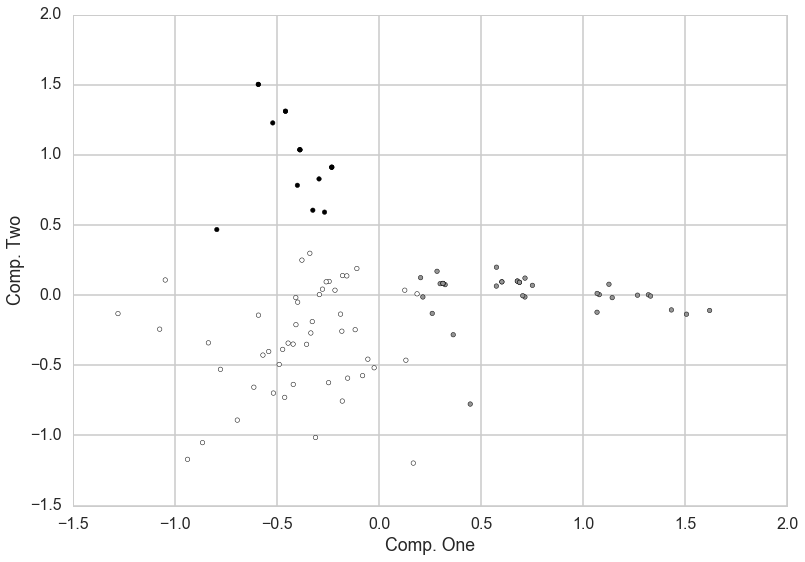

In [21]:
plt.scatter(df_pca['x'], df_pca['y'], c=df_pca['cluster_label'])
plt.xlabel('Comp. One')
plt.ylabel('Comp. Two')
plt.show()

Based on the scatter plot created from the PCA dataframe, the ideal number of clusters is three.  

In [50]:
df_combined=pd.merge(df_merged, df_pca, how='outer', on='customer_name')

In [55]:
#Grouping Wines by color by adding a new column if the wine is red or not
red_dict = {'Champagne':0, 'Pinot Noir':1, 'Prosecco':0, 'Espumante':0, 'Cabernet Sauvignon':1, 'Malbec':1, 'Merlot':1, 'Pinot Grigio':0, 'Chardonnay':0}
df_combined['red'] = df_combined['varietal']
df_combined.replace({'red':red_dict}, inplace=True)

#Grouping the Locations by their continents
cont_dict = {'France':0, 'Australia':1, 'Chile':2, 'Oregon':3, 'South Africa':4, 'Italy':0, 'Germany':0, 'California':3, 'New Zealand':1}
df_combined['cont'] = df_combined['origin']
df_combined.replace({'cont':cont_dict}, inplace=True)

In [56]:
df_combined.groupby(['cluster_label']).campaign.value_counts()

cluster_label  campaign 
0.0            March        24
               December     19
               June         13
               November     13
               October      13
               February     12
               July         12
               May          12
               April        11
               August       11
               September     7
               January       6
1.0            March        20
               August       13
               December     13
               October      13
               July         11
               May           9
               February      8
               January       7
               September     7
               November      5
               June          4
               April         1
2.0            December      9
               January       7
               August        6
               March         6
               November      5
               April         4
               October       4
              

In [57]:
df_combined.groupby(['cluster_label']).cont.value_counts()

cluster_label  cont
0.0            0       73
               1       24
               2       22
               3       21
               4       13
1.0            0       61
               1       22
               3       13
               2        8
               4        7
2.0            0       30
               3        8
               1        6
               2        5
               4        5
Name: cont, dtype: int64

In [58]:
df_combined.groupby(['cluster_label']).origin.value_counts()

cluster_label  origin      
0.0            France          57
               Chile           22
               Australia       16
               Oregon          14
               South Africa    13
               Italy           11
               New Zealand      8
               California       7
               Germany          5
1.0            France          42
               Australia       19
               Italy           10
               Germany          9
               Oregon           9
               Chile            8
               South Africa     7
               California       4
               New Zealand      3
2.0            France          27
               California       5
               Chile            5
               South Africa     5
               Australia        4
               Oregon           3
               Italy            2
               New Zealand      2
               Germany          1
Name: origin, dtype: int64

In [59]:
df_combined.groupby(['cluster_label']).varietal.value_counts()

cluster_label  varietal          
0.0            Champagne             32
               Espumante             20
               Prosecco              20
               Cabernet Sauvignon    19
               Malbec                17
               Merlot                13
               Pinot Noir            13
               Pinot Grigio          10
               Chardonnay             9
1.0            Champagne             33
               Pinot Noir            25
               Prosecco              17
               Espumante             14
               Cabernet Sauvignon     7
               Malbec                 6
               Merlot                 4
               Pinot Grigio           4
               Chardonnay             1
2.0            Champagne             14
               Malbec                 9
               Espumante              6
               Pinot Noir             6
               Prosecco               5
               Cabernet Sauvignon     4
      

In [60]:
df_combined.groupby(['cluster_label']).red.value_counts()

cluster_label  red
0.0            0      91
               1      62
1.0            0      69
               1      42
2.0            0      32
               1      22
Name: red, dtype: int64

Interestingly, March is the most successful month sales-wise with the first two clusters but not the third.  

White wines also big sellers across all groups, but group one has more red wine sales than the other two groups.

European wines are also the biggest sellers.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

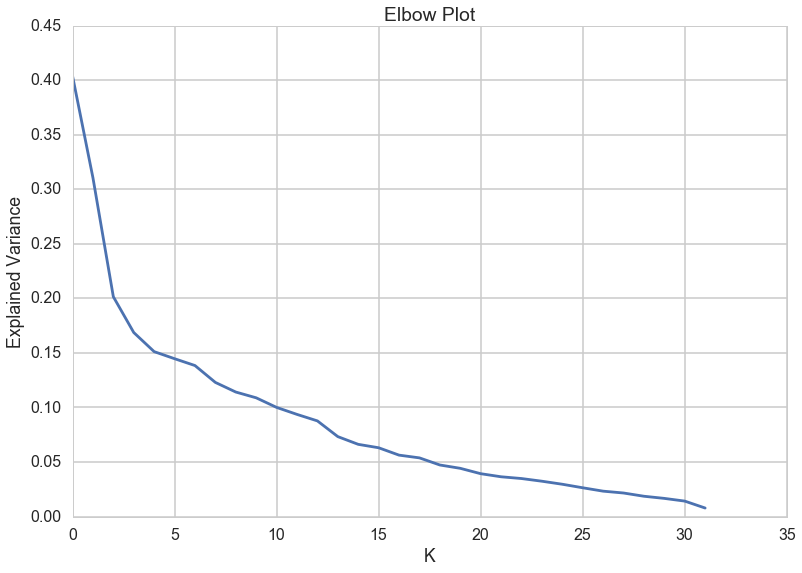

In [26]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.plot(pca.explained_variance_)
plt.xlabel('K')
plt.ylabel('Explained Variance')
plt.title('Elbow Plot')
plt.show()

The biggest drops in the explained variance is somewhere around 2 or clusters, so that would be the optimal number of clusters

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [35]:
# Your turn
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

algorithms=['AffinityPropagation', 'SpectralClustering', 'AgglomerativeClustering','DBSCAN']
algor_scores=pd.Series(index=algorithms)

In [42]:
dampings = [0.5, 0.6, 0.7, 0.8, 0.9]
best_score = 0.0
for damping in dampings:
    ap = AffinityPropagation(damping=damping)
    labels = ap.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("Damping =", damping,
          "Avg. Silhouette Score :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_damping = damping
        
print('Optimal damping Parameter:', best_damping)
algor_scores.loc['AffinityPropagation'] = best_score

Damping = 0.5 Avg. Silhouette Score : 0.1300214652665857
Damping = 0.6 Avg. Silhouette Score : 0.11083805384331491
Damping = 0.7 Avg. Silhouette Score : 0.11083805384331491
Damping = 0.8 Avg. Silhouette Score : 0.11083805384331491
Damping = 0.9 Avg. Silhouette Score : 0.12114180206927802
Optimal damping Parameter: 0.5


In [45]:
#Spectral Clustering
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    sc = SpectralClustering(n_clusters=n_clusters)
    labels = sc.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("n_clusters =", n_clusters,
          "Avg. Silhouette Score :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algor_scores.loc['SpectralClustering'] = best_score

n_clusters = 2 Avg. Silhouette Score : 0.05856211114290362
n_clusters = 3 Avg. Silhouette Score : 0.10151199120166161
n_clusters = 4 Avg. Silhouette Score : 0.02925321091580316
n_clusters = 5 Avg. Silhouette Score : 0.02334707253902809
n_clusters = 6 Avg. Silhouette Score : 0.04445270188580057
n_clusters = 7 Avg. Silhouette Score : 0.053440057194548744
n_clusters = 8 Avg. Silhouette Score : 0.0462726881808759
n_clusters = 9 Avg. Silhouette Score : 0.05305069624657449
n_clusters = 10 Avg. Silhouette Score : 0.04120784404519152
Best n_clusters parameter: 3


In [46]:
#Agglomerative Clustering
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    labels = ac.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("n_clusters =", n_clusters,
          "Avg. Silhouette Score :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Optimal n_clusters Parameter:',best_n_clusters)
algor_scores.loc['AgglomerativeClustering'] = best_score

n_clusters = 2 Avg. Silhouette Score : 0.0790946165526936
n_clusters = 3 Avg. Silhouette Score : 0.11369126538255597
n_clusters = 4 Avg. Silhouette Score : 0.1265604340722505
n_clusters = 5 Avg. Silhouette Score : 0.1386902082034632
n_clusters = 6 Avg. Silhouette Score : 0.10825512123275303
n_clusters = 7 Avg. Silhouette Score : 0.11631233897872446
n_clusters = 8 Avg. Silhouette Score : 0.1239899082339297
n_clusters = 9 Avg. Silhouette Score : 0.13251611762022183
n_clusters = 10 Avg. Silhouette Score : 0.13209448659856704
Optimal n_clusters Parameter: 5


In [48]:
#DBSCAN
range_min_samples = [1, 2, 3]
best_score = 0.0
for min_samples in range_min_samples:
    db = DBSCAN(min_samples=min_samples)
    labels = db.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("min_samples =", min_samples,
          "Avg. Silhouette Score :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_min_samples = min_samples
        
print('Best min_samples parameter:',best_min_samples)
algor_scores.loc['DBSCAN'] = best_score

min_samples = 1 Avg. Silhouette Score : 0.1919191919191919
min_samples = 2 Avg. Silhouette Score : -0.016579951407723878
min_samples = 3 Avg. Silhouette Score : -0.1072081107290735
Best min_samples parameter: 1


In [49]:
print(algor_scores)

AffinityPropagation        0.130021
SpectralClustering         0.101512
AgglomerativeClustering    0.138690
DBSCAN                     0.191919
dtype: float64


None of the models were very good, each performing below 0.2.  This follows the logic of the visualization of the data, where no cluster was easily found.  The best performing model was the DBSCAN with min_sample=1.